### Marine trash detection

In [12]:
#@title { form-width: "1%", display-mode: "form" }
# mounting google drive to load dataset
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Installing and importing libraries

In [13]:
!pip install fiftyone
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob

In [14]:
import yaml, cv2, os
from torchvision import transforms as T
from torchvision.transforms import functional as F
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from pathlib import Path
import pdb
import os
from pycocotools.coco import COCO
from skimage import io
from PIL import Image

In [15]:
from IPython.core.display import HTML
from IPython.display import Image
from collections import Counter

from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from wordcloud import WordCloud
from plotly import tools
import seaborn as sns
from PIL import Image

import tensorflow as tf
import numpy as np

init_notebook_mode(connected=True)
%matplotlib inline 

In [16]:
from imutils import paths
import argparse

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

1.2. Loading the datasets

1.2.1. Setting the paths for exploration

In [18]:
src_root = Path('gdrive/MyDrive/marine_trash')
src_subset = Path('train')
src_file = src_root/Path('train/train_annotations.json')
src_desc = 'marine_trash'

coco_obj = COCO(src_file)
# COCO API class that loads a COCO-style annotation file and prepares data structures.

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


1.2.2. Loading the annotation file

In [19]:
trn_json = json.load( (src_file).open() )

### Exploring

Getting a quick look at the training dataset

In [20]:
dataset_type = fo.types.COCODetectionDataset # The type of the dataset being imported
train_image_path = "gdrive/MyDrive/marine_trash/train"
# The directory containing the source images
data_path = train_image_path

# The path to the COCO labels JSON file
labels_path = "gdrive/MyDrive/marine_trash/train/train_annotations.json"

# Import the dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path,
)

 100% |███████████████| 1736/1736 [3.6s elapsed, 0s remaining, 485.9 samples/s]      


In [21]:
print(dataset)

Name:        2021.11.16.21.17.48
Media type:  image
Num samples: 1736
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [22]:
print(dataset.first())

<Sample: {
    'id': '61941ffc5bdd9446ca3590ef',
    'media_type': 'image',
    'filepath': '/content/gdrive/MyDrive/marine_trash/train/frame_01230_png_jpg.rf.455f416addd036425ea52106477874bb.jpg',
    'tags': BaseList([]),
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 416,
        'height': 416,
        'num_channels': None,
    }>,
    'ground_truth': <Detections: {
        'detections': BaseList([
            <Detection: {
                'id': '61941ffc5bdd9446ca3590ee',
                'attributes': BaseDict({}),
                'tags': BaseList([]),
                'label': 'trash_plastic',
                'bounding_box': BaseList([
                    0.40865384615384615,
                    0.4326923076923077,
                    0.2283653846153846,
                    0.25,
                ]),
                'mask': None,
                'confidence': None,
                'index': None,
                'iscrowd': 0,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


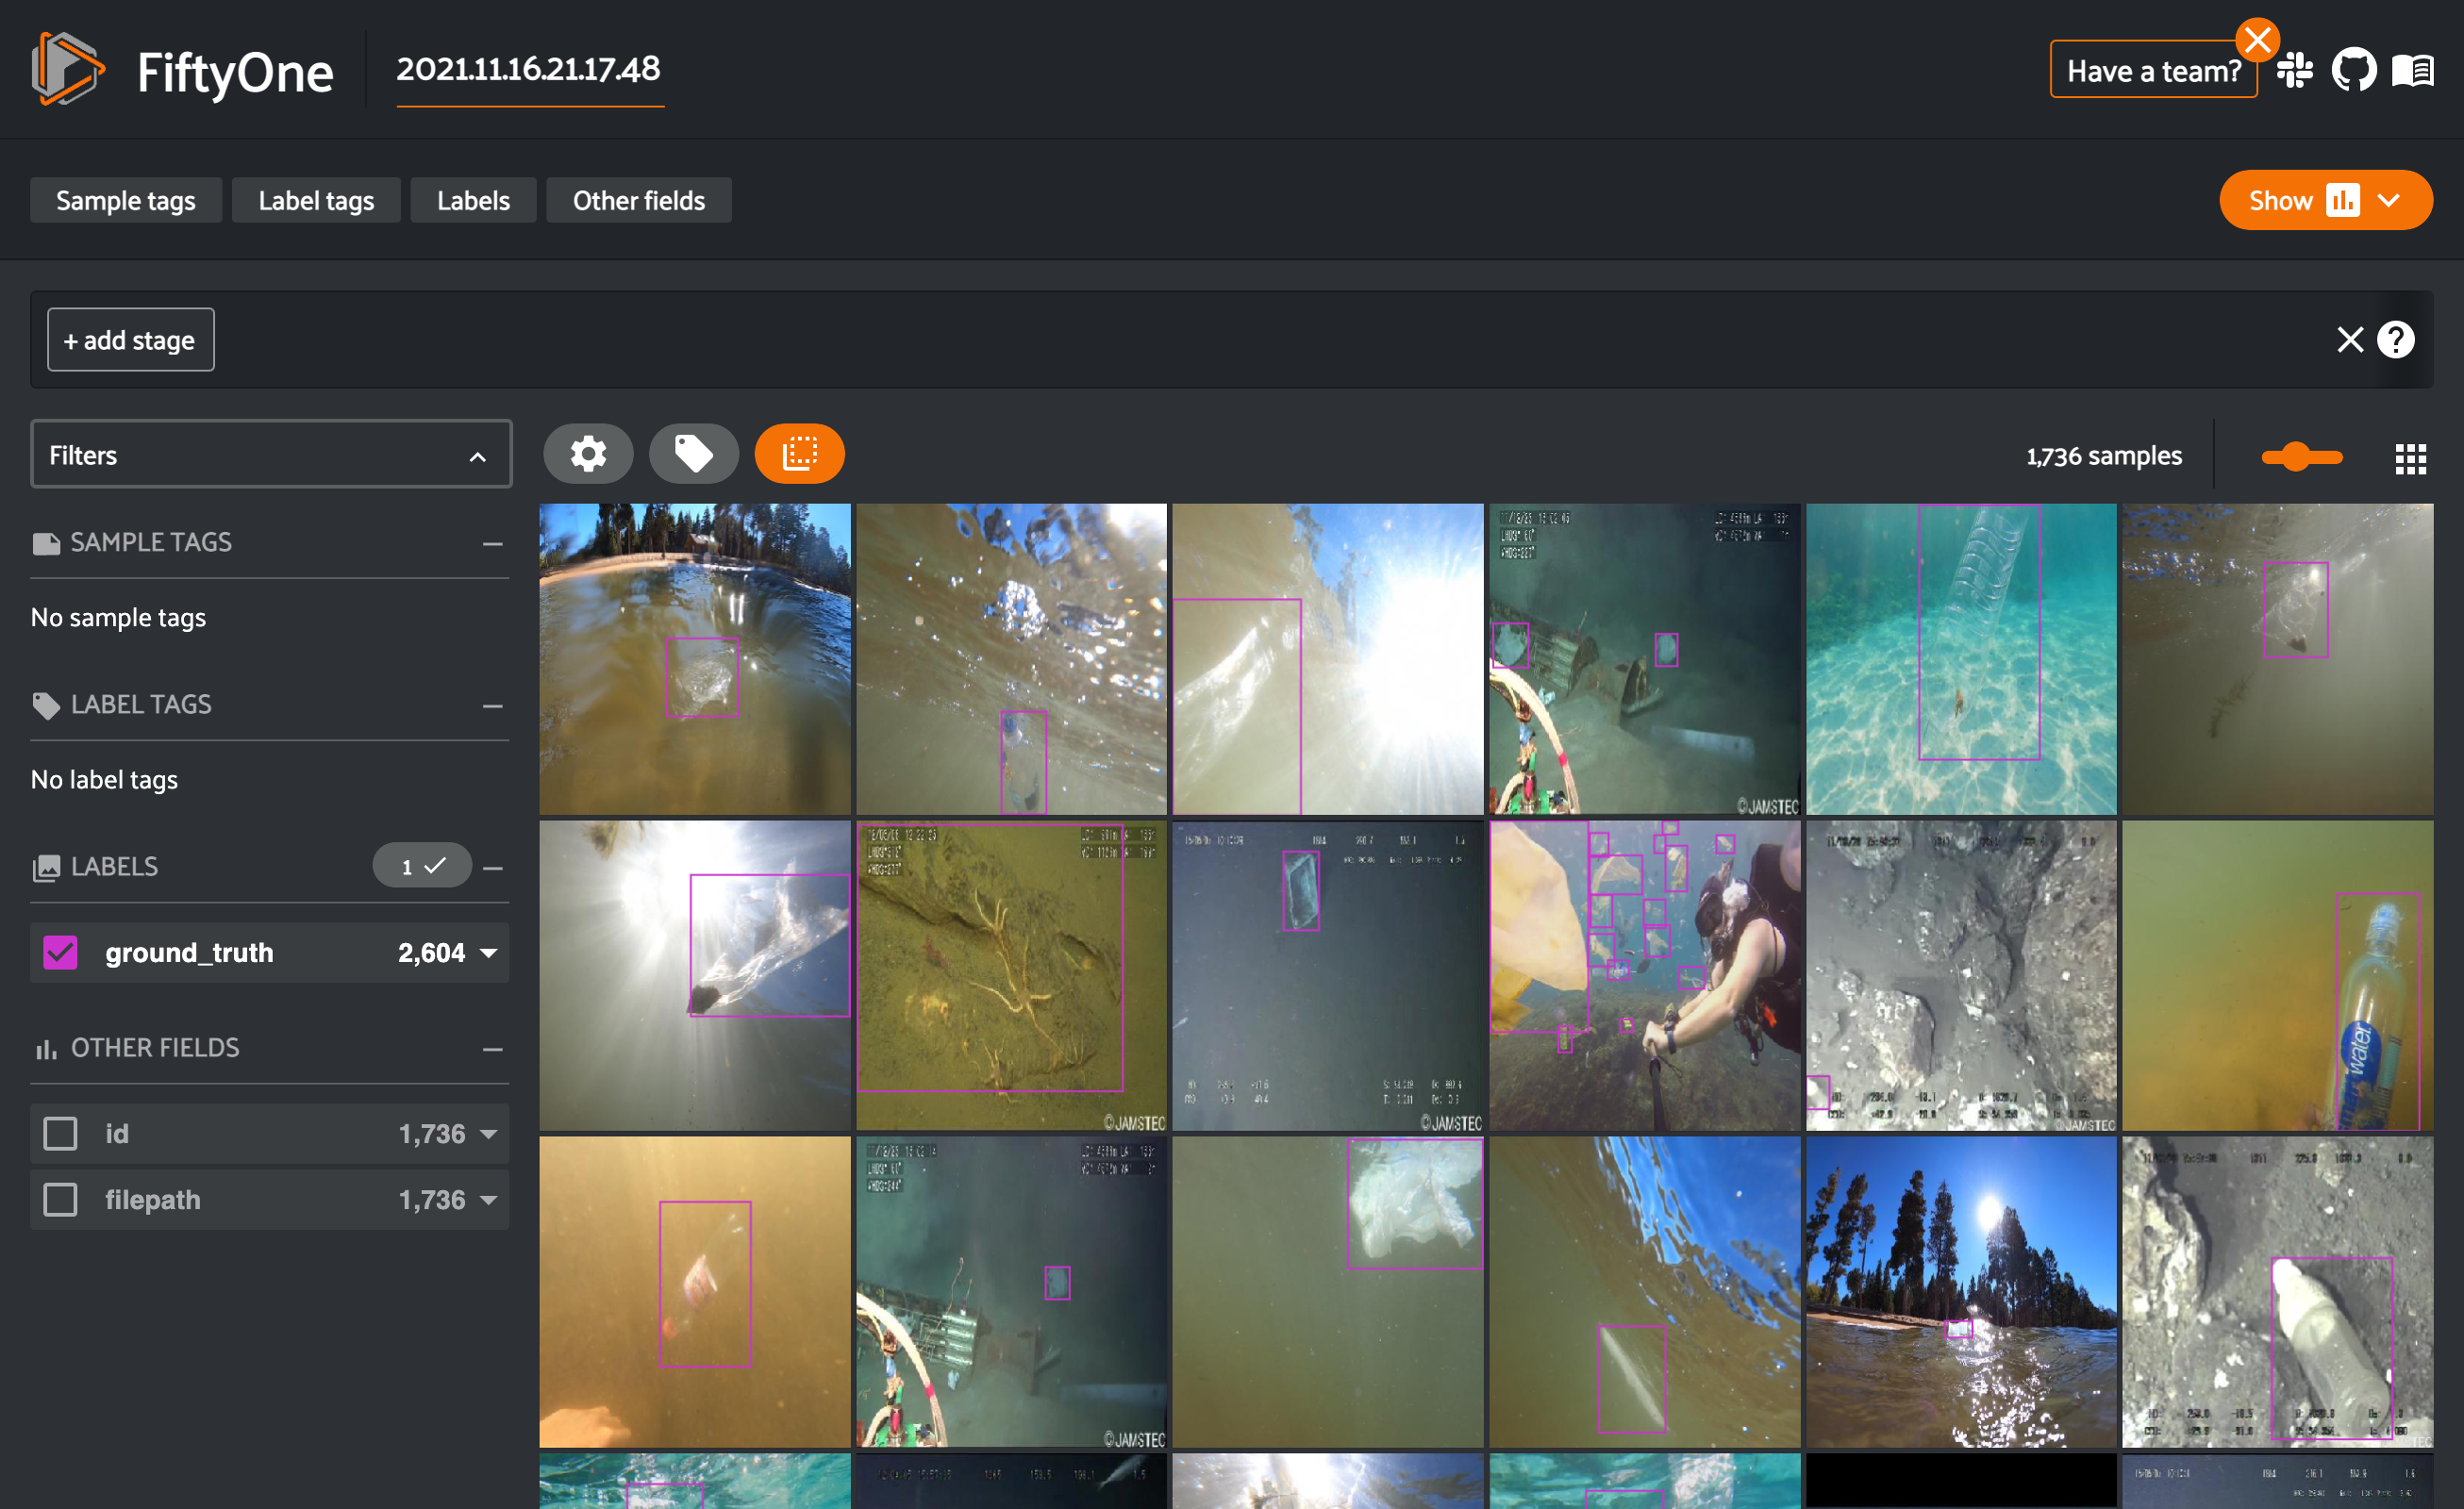

<IPython.core.display.Javascript object>

In [23]:
session = fo.launch_app(dataset)

In [24]:
print(trn_json.keys())

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


In [25]:
# turning the keys into variables so it'd autocomplete and make it easier
INFO, LICENSES, CATEGORIES, IMAGES, ANNOTATIONS = 'info', 'licenses', 'categories', 'images', 'annotations'

In [26]:
print(trn_json[INFO])

{'year': '2021', 'version': '1', 'description': 'Exported from roboflow.ai', 'contributor': '', 'url': 'https://public.roboflow.ai/object-detection/undefined', 'date_created': '2021-11-13T16:04:37+00:00'}


In [27]:
print(trn_json[LICENSES])

[{'id': 1, 'url': 'https://creativecommons.org/licenses/by/4.0/', 'name': 'CC BY 4.0'}]


In [28]:
print(trn_json[CATEGORIES])
# there's only one category: trash_plastic

[{'id': 1, 'name': 'trash_plastic'}]


In [29]:
print(trn_json[IMAGES][:2])

[{'id': 0, 'license': 1, 'file_name': 'frame_01230_png_jpg.rf.455f416addd036425ea52106477874bb.jpg', 'height': 416, 'width': 416, 'date_captured': '2021-11-13T16:04:37+00:00'}, {'id': 1, 'license': 1, 'file_name': 'frame_01050_png_jpg.rf.453d9b9e108ce90e2e1c9629cd963a35.jpg', 'height': 416, 'width': 416, 'date_captured': '2021-11-13T16:04:37+00:00'}]


In [30]:
print(trn_json[ANNOTATIONS][:2])

[{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [170, 180, 95, 104], 'area': 9880, 'segmentation': [], 'iscrowd': 0}, {'id': 1, 'image_id': 1, 'category_id': 1, 'bbox': [194, 278, 60, 137], 'area': 8220, 'segmentation': [], 'iscrowd': 0}]


In [31]:
# Basic High Level Information

n_images = len(trn_json[IMAGES])
n_boxes = len(trn_json[ANNOTATIONS])
n_categ = len(trn_json[CATEGORIES])

# height, width
heights = [x['height'] for x in trn_json[IMAGES]]
widths = [x['width'] for x in trn_json[IMAGES]]

In [32]:
print(f'Dataset Name: {src_desc}.')
print(f'Number of images: {n_images}')
print(f'Number of bounding boxes: , {n_boxes}')
print(f'Number of classes: {n_categ}')
print(f'Max height: {max(heights)}')
print(f'Min height: {min(heights)}')
print(f'Average height: {int(sum(heights)/len(heights))}')
print(f'Max min avg width: {max(widths)}, {min(widths)}, {int(sum(widths)/len(widths))}')

Dataset Name: marine_trash.
Number of images: 1736
Number of bounding boxes: , 2604
Number of classes: 1
Max height: 416
Min height: 416
Average height: 416
Max min avg width: 416, 416, 416


Based on this output, it's very likely all the images are same size. Let's check:

In [33]:
diff_size = 0
avg_s = 416
for x in trn_json[IMAGES]:
  if x['height'] != 416:
    diff_size += 1
  if x['width'] != 416:
    diff_size != 1
if diff_size == 0:
  print('All the images in the training set are the same size.')
print(diff_size)

All the images in the training set are the same size.
0


Checking the distributions of objects per image


In [34]:
img2nboxes = {} # mapping "image id" to "number of boxes"

for ann in trn_json[ANNOTATIONS]:
    img_id = ann['image_id']
    
    if img_id in img2nboxes.keys():
        img2nboxes[img_id] += 1
    else:
        img2nboxes[img_id] = 1

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

NumExpr defaulting to 2 threads.


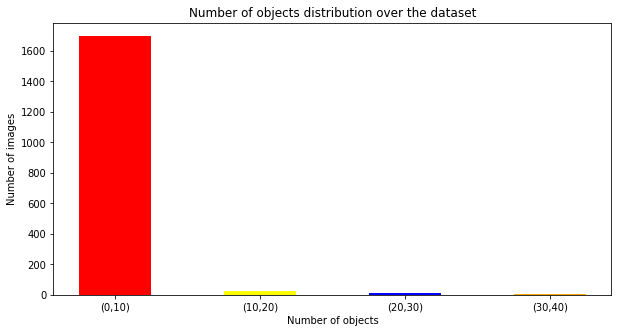

Number of images having at least one box:  1736
Min number of boxes per image:  1
Max number of boxes per image:  36
Avg number of boxes per image:  1


In [35]:
out = pd.cut(nboxes_list, bins=np.arange(0,max_nboxes+10,10), include_lowest=True)

counts = out.value_counts().values
labels = [(int(i.left),int(i.right)) for i in out.value_counts().index.categories]
C = ['red', 'yellow', 'blue', 'orange']

graph_xind = [i[0] for i in labels] 
ticks = [ '('+str(i[0])+','+ str(i[1])+')' for i in labels]

plt.figure(figsize=(10,5))
plt.bar(graph_xind, counts, tick_label=ticks, width=5, color=C)
plt.xlabel('Number of objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution over the dataset')
plt.show()

print("Number of images having at least one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

Computing the uniqueness of the training set samples

In [36]:
fob.compute_uniqueness(dataset)

 100% |████|  100.6Mb/100.6Mb [276.1ms elapsed, 0s remaining, 364.3Mb/s]      
Generating embeddings...
 100% |███████████████| 1736/1736 [7.4m elapsed, 0s remaining, 4.2 samples/s]    
Computing uniqueness...
Uniqueness computation complete


The code above populates a uniqueness field on each sample that contains the sample’s uniqueness score. To confirm this:

In [37]:
print(dataset)
# there's now a uniqueness field

Name:        2021.11.16.21.17.48
Media type:  image
Num samples: 1736
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    uniqueness:   fiftyone.core.fields.FloatField


In [38]:
print(dataset.first())

<Sample: {
    'id': '61941ffc5bdd9446ca3590ef',
    'media_type': 'image',
    'filepath': '/content/gdrive/MyDrive/marine_trash/train/frame_01230_png_jpg.rf.455f416addd036425ea52106477874bb.jpg',
    'tags': BaseList([]),
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 416,
        'height': 416,
        'num_channels': None,
    }>,
    'ground_truth': <Detections: {
        'detections': BaseList([
            <Detection: {
                'id': '61941ffc5bdd9446ca3590ee',
                'attributes': BaseDict({}),
                'tags': BaseList([]),
                'label': 'trash_plastic',
                'bounding_box': BaseList([
                    0.40865384615384615,
                    0.4326923076923077,
                    0.2283653846153846,
                    0.25,
                ]),
                'mask': None,
                'confidence': None,
                'index': None,
                'iscrowd': 0,

Visually inspecting the least unique images in the dataset.

In [39]:
# Sort in increasing order of uniqueness (least unique first)
dups_view = dataset.sort_by("uniqueness")

# view
session.view = dups_view

It's very easy to see visually that some images are quite similar. This is expected as one of the sources of the images was a video.
It's important to deal with those duplicates and near-duplicates to avoid:


*   the neural network learning patterns specific to the duplicate/near-duplicate images
* 		hindering the model's ability to generalise.

2. Preparation and preprocessing

First, dealing with duplicates and near-duplicates.
Above, Fiftyone computed uniqueness and gave a visual represenation a visual representation of duplicates/near-duplicates. However, in order to remove them, I'll detect them again using a different method: hashing.

Image hashing, according to https://www.pyimagesearch.com/, involves:

"
*   Examining the contents of an image

*   Constructing a hash value that uniquely identifies an input image based on the contents of an image.

"

Images that are visually similar should have similar hashes as well.

In [40]:
!pip install tensorflow # it's needed as a dependancy for the Fiftyone functions and methods used here
import fiftyone.core.utils as fou

In [41]:
from collections import Counter
from fiftyone import ViewField as F

In [42]:
# iterating over the images/samples and computing their hashes
for sample in dataset:
    sample["file_hash"] = fou.compute_filehash(sample.filepath)
    sample.save()

print(dataset)

Name:        2021.11.16.21.17.48
Media type:  image
Num samples: 1736
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    uniqueness:   fiftyone.core.fields.FloatField
    file_hash:    fiftyone.core.fields.IntField


In [43]:
sample = dataset.first()
print(sample)

<Sample: {
    'id': '61941ffc5bdd9446ca3590ef',
    'media_type': 'image',
    'filepath': '/content/gdrive/MyDrive/marine_trash/train/frame_01230_png_jpg.rf.455f416addd036425ea52106477874bb.jpg',
    'tags': BaseList([]),
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 416,
        'height': 416,
        'num_channels': None,
    }>,
    'ground_truth': <Detections: {
        'detections': BaseList([
            <Detection: {
                'id': '61941ffc5bdd9446ca3590ee',
                'attributes': BaseDict({}),
                'tags': BaseList([]),
                'label': 'trash_plastic',
                'bounding_box': BaseList([
                    0.40865384615384615,
                    0.4326923076923077,
                    0.2283653846153846,
                    0.25,
                ]),
                'mask': None,
                'confidence': None,
                'index': None,
                'iscrowd': 0,

In [44]:
# locating images with similar hashes i.e. duplicates/near-duplicates
filehash_counts = Counter(sample.file_hash for sample in dataset)
dup_filehashes = [k for k, v in filehash_counts.items() if v > 1]

print("Number of duplicate file hashes: %d" % len(dup_filehashes))

Number of duplicate file hashes: 87


In [45]:
dup_view = (dataset.match(F("file_hash").is_in(dup_filehashes)).sort_by("file_hash"))     # Extract samples with duplicate file hashes then sort by file hash so duplicates will be adjacent


print("Number of images that have a duplicate: %d" % len(dup_view))
print("Number of duplicates: %d" % (len(dup_view) - len(dup_filehashes)))

Number of images that have a duplicate: 174
Number of duplicates: 87


Deleting the duplicates

In [46]:
print("Length of dataset before: %d" % len(dataset))

_dup_filehashes = set()
for sample in dup_view:
    if sample.file_hash not in _dup_filehashes:
        _dup_filehashes.add(sample.file_hash)
        continue

    del dataset[sample.id]

print("Length of dataset after: %d" % len(dataset))

# Verify that the dataset no longer contains any duplicates
print("Number of unique file hashes: %d" % len({s.file_hash for s in dataset}))

Length of dataset before: 1736
Length of dataset after: 1649
Number of unique file hashes: 1649


In [47]:
EXPORT_DIR = train_image_path + "edit/image-deduplication"
#LABELS_PATH = EXPORT_DIR + "/train_coco.json"
#labels_path= LABELS_PATH
dataset.export
dataset.export(label_field="ground_truth", export_dir=EXPORT_DIR, dataset_type=fo.types.COCODetectionDataset)

Directory 'gdrive/MyDrive/marine_trash/trainedit/image-deduplication' already exists; export will be merged with existing files
 100% |███████████████| 1649/1649 [5.4m elapsed, 0s remaining, 5.6 samples/s]      


Checking the results the new training set and confirming the annotations are safe

In [48]:
no_dups_dataset = fo.Dataset.from_dir(
    EXPORT_DIR,
    fo.types.COCODetectionDataset,
    name="clean_train",
)

 100% |███████████████| 1649/1649 [3.7s elapsed, 0s remaining, 485.1 samples/s]      


In [49]:
print(no_dups_dataset)

Name:        clean_train
Media type:  image
Num samples: 1649
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [50]:
print(no_dups_dataset.first())

<Sample: {
    'id': '6194231c5bdd9446ca35db8b',
    'media_type': 'image',
    'filepath': '/content/gdrive/MyDrive/marine_trash/trainedit/image-deduplication/data/frame_01230_png_jpg.rf.455f416addd036425ea52106477874bb-2.jpg',
    'tags': BaseList([]),
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 416,
        'height': 416,
        'num_channels': None,
    }>,
    'ground_truth': <Detections: {
        'detections': BaseList([
            <Detection: {
                'id': '6194231c5bdd9446ca35db8a',
                'attributes': BaseDict({}),
                'tags': BaseList([]),
                'label': 'trash_plastic',
                'bounding_box': BaseList([
                    0.40865384615384615,
                    0.4326923076923077,
                    0.2283653846153846,
                    0.25,
                ]),
                'mask': None,
                'confidence': None,
                'index': None

Loading the new annotations file

In [51]:
lbls_file = EXPORT_DIR+"/labels.json"
no_dups_trn_json = json.load( (Path(lbls_file)).open() )

In [52]:
no_dups_trn_json.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

Now just repeating the same process as before but with the new, no-duplicates dataset

In [53]:
coco_obj1 = COCO(Path(lbls_file))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [54]:
print(no_dups_trn_json[CATEGORIES])

[{'id': 0, 'name': '0', 'supercategory': None}, {'id': 1, 'name': 'trash_plastic', 'supercategory': None}]


In [55]:
print(no_dups_trn_json[IMAGES][:2])

[{'id': 1, 'file_name': 'frame_01230_png_jpg.rf.455f416addd036425ea52106477874bb-2.jpg', 'height': 416, 'width': 416, 'license': None, 'coco_url': None}, {'id': 2, 'file_name': 'frame_01050_png_jpg.rf.453d9b9e108ce90e2e1c9629cd963a35-2.jpg', 'height': 416, 'width': 416, 'license': None, 'coco_url': None}]


In [56]:
print(no_dups_trn_json[ANNOTATIONS][:2])

[{'id': 1, 'image_id': 1, 'category_id': 1, 'bbox': [170.0, 180.0, 95.0, 104.0], 'area': 9880.0, 'iscrowd': 0}, {'id': 2, 'image_id': 2, 'category_id': 1, 'bbox': [194.0, 278.0, 59.99999999999999, 137.0], 'area': 8219.999999999998, 'iscrowd': 0}]


In [57]:
# Basic High Level Information

n_images1 = len(no_dups_trn_json[IMAGES])
n_boxes1 = len(no_dups_trn_json[ANNOTATIONS])
n_categ1 = len(no_dups_trn_json[CATEGORIES])

# height, width
heights1 = [x['height'] for x in no_dups_trn_json['images']]
widths1 = [x['width'] for x in no_dups_trn_json['images']]

In [58]:
print(f'Number of images: {n_images1}')
print(f'Number of bounding boxes: , {n_boxes1}')
print(f'Number of classes: {n_categ1}')
print(f'Max height: {max(heights1)}')
print(f'Min height: {min(heights1)}')
print(f'Average height: {int(sum(heights1)/len(heights1))}')
print(f'Max min avg width: {max(widths1)}, {min(widths1)}, {int(sum(widths1)/len(widths1))}')

Number of images: 1649
Number of bounding boxes: , 2517
Number of classes: 2
Max height: 416
Min height: 416
Average height: 416
Max min avg width: 416, 416, 416


In [59]:
# Objects per image distribution

img2nboxes = {} # mapping "image id" to "number of boxes"

for ann in no_dups_trn_json['annotations']:
  img_id = ann['image_id']
  
  if img_id in img2nboxes.keys():
    img2nboxes[img_id] += 1
  else:
    img2nboxes[img_id] = 1

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

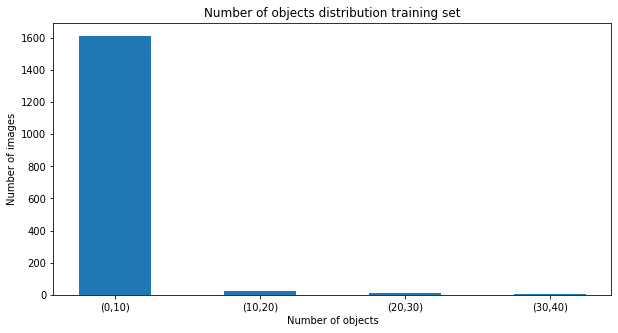

Number of images having atleast one box:  1649
Min number of boxes per image:  1
Max number of boxes per image:  36
Avg number of boxes per image:  1


In [63]:
out1 = pd.cut(nboxes_list, bins=np.arange(0,max_nboxes+10,10), include_lowest=True)

counts = out1.value_counts().values
labels = [(int(i.left),int(i.right)) for i in out1.value_counts().index.categories]

graph_xind = [i[0] for i in labels] 
ticks = [ '('+str(i[0])+','+ str(i[1])+')' for i in labels]

plt.figure(figsize=(10,5))
plt.bar(graph_xind, counts, tick_label=ticks, width=5)
plt.xlabel('Number of objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution training set')
plt.show()

print("Number of images having atleast one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

In [64]:
train_labels = Counter(no_dups_trn_json)

xvalues = list(train_labels.keys())
yvalues = list(train_labels.values())

trace1 = go.Bar(x=xvalues, y=yvalues, opacity=0.8, name="year count", marker=dict(color='rgba(20, 20, 20, 1)'))
layout = dict(width=800, title='Distribution of different labels in the train dataset', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);